In [1]:
%run flow_tools.py

In [2]:
from matplotlib.path import Path
from matplotlib import patches

In [3]:
folders = ['../data/20220429_SARSNotch_WA1/',
           '../data/20220429_SARSNotch_Delta/']

In [4]:
df = pd.concat([load_data(folder, colnames = ["WellName", "Receiver","Strain",'MOI','Replicate','Plate'])
               for folder in folders], ignore_index=True)

In [5]:
#remove NAs
df2= df.loc[(df.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

In [6]:
#define gate for FSC-A vs SSC-A
fsc_ssc_verts = [(1e4, 1e4),
              (1e5, 1e4),
              (2.5e5, 1e5),
              (2.5e5, 2.5e5),
              (4e4, 2.5e5),
              (1e4, 5e4),
              (1e4, 5e4),
              (1e4, 1e4)]
fsc_ssc_gate = Path(fsc_ssc_verts)

ssc_verts = [(0, 1e4),
              (2e5, 1.8e5),
              (2.6e5, 1.8e5),
              (2.5e5, 1.3e5),
              (1.25e5, 7.5e4),
              (1e4, 0),
              (0, 1e4)]
ssc_gate = Path(ssc_verts)

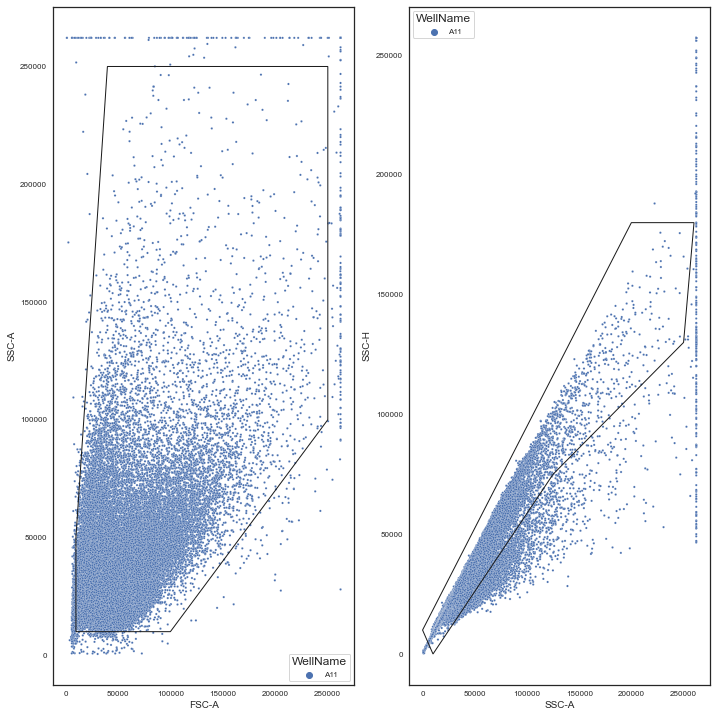

In [12]:
fig, axs = plt.subplots(1,2, figsize=[10,10])
sns.scatterplot(data=df2[(df2['WellName'].isin(['A11']))], x='FSC-A', y='SSC-A', marker='o', s=5, edgecolors=None, ax=axs[0], hue='WellName')
sns.scatterplot(data=df2[df2['WellName'].isin(['A11'])], x='SSC-A', y='SSC-H', marker='o', s=5, edgecolors=None, ax=axs[1], hue='WellName')
patch = patches.PathPatch(fsc_ssc_gate, facecolor="None", edgecolor='k')
axs[0].add_patch(patch)

patch = patches.PathPatch(ssc_gate, facecolor="None", edgecolor='k')
axs[1].add_patch(patch)

plt.tight_layout()

In [7]:
#filter to gate
df2 = df2[fsc_ssc_gate.contains_points(df2[['FSC-A','SSC-A']].to_numpy())]
df2 = df2[ssc_gate.contains_points(df2[['SSC-A', 'SSC-H']].to_numpy())]
# # gate on singlets
# df2 = gate_density(df2, 0.1, x_var='SSC-A',y_var='SSC-H')

for col in df2.columns:
        if df2[col].dtype=="float32":
            df2["log"+ col]=df2[col].apply(math.log10)

<AxesSubplot:xlabel='logAPC-Cy7-A', ylabel='Density'>

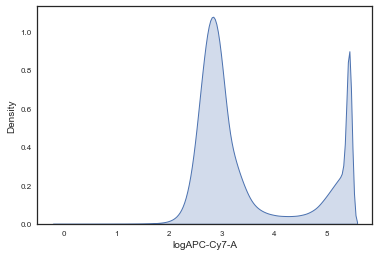

In [33]:
sns.kdeplot(data=df2, x='logAPC-Cy7-A', shade=True)

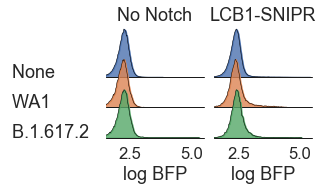

In [37]:
senders = ['None', 'WA1', 'B.1.617.2']
notches = ['No Notch','LCB1-SNIPR']
g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                           (df2['MOI'].isin(['0','10'])) &
                           (df2['Strain'].isin(senders)) &
                           (df2['logAPC-Cy7-A'] < 4) &
                           (df2['logFITC-A'] > 5)],
                  row='Strain', col='Receiver', sharey=False, aspect=2, height=1, 
                  hue='Strain', row_order=senders, col_order=notches, hue_order=senders, xlim=[1.5, 5.5])
g.map(sns.kdeplot, "logDAPI-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
g.map(sns.kdeplot, "logDAPI-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.4, wspace=0.1)

left_axes = [g.facet_axis(r, 0) for r in range(len(senders))]
for ax in left_axes:
    dose = ax.get_title().split("=")[1].split('|')[0]
    ax.text(-1,0.1, "{}".format(dose), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

g.set_titles("")
top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
for ax, notch in zip(top_axes, notches):
    ax.set_title(notch)
[ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

# Remove axes details that don't play well with overlap
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set_xlabels("log BFP")
g.set_ylabels('')

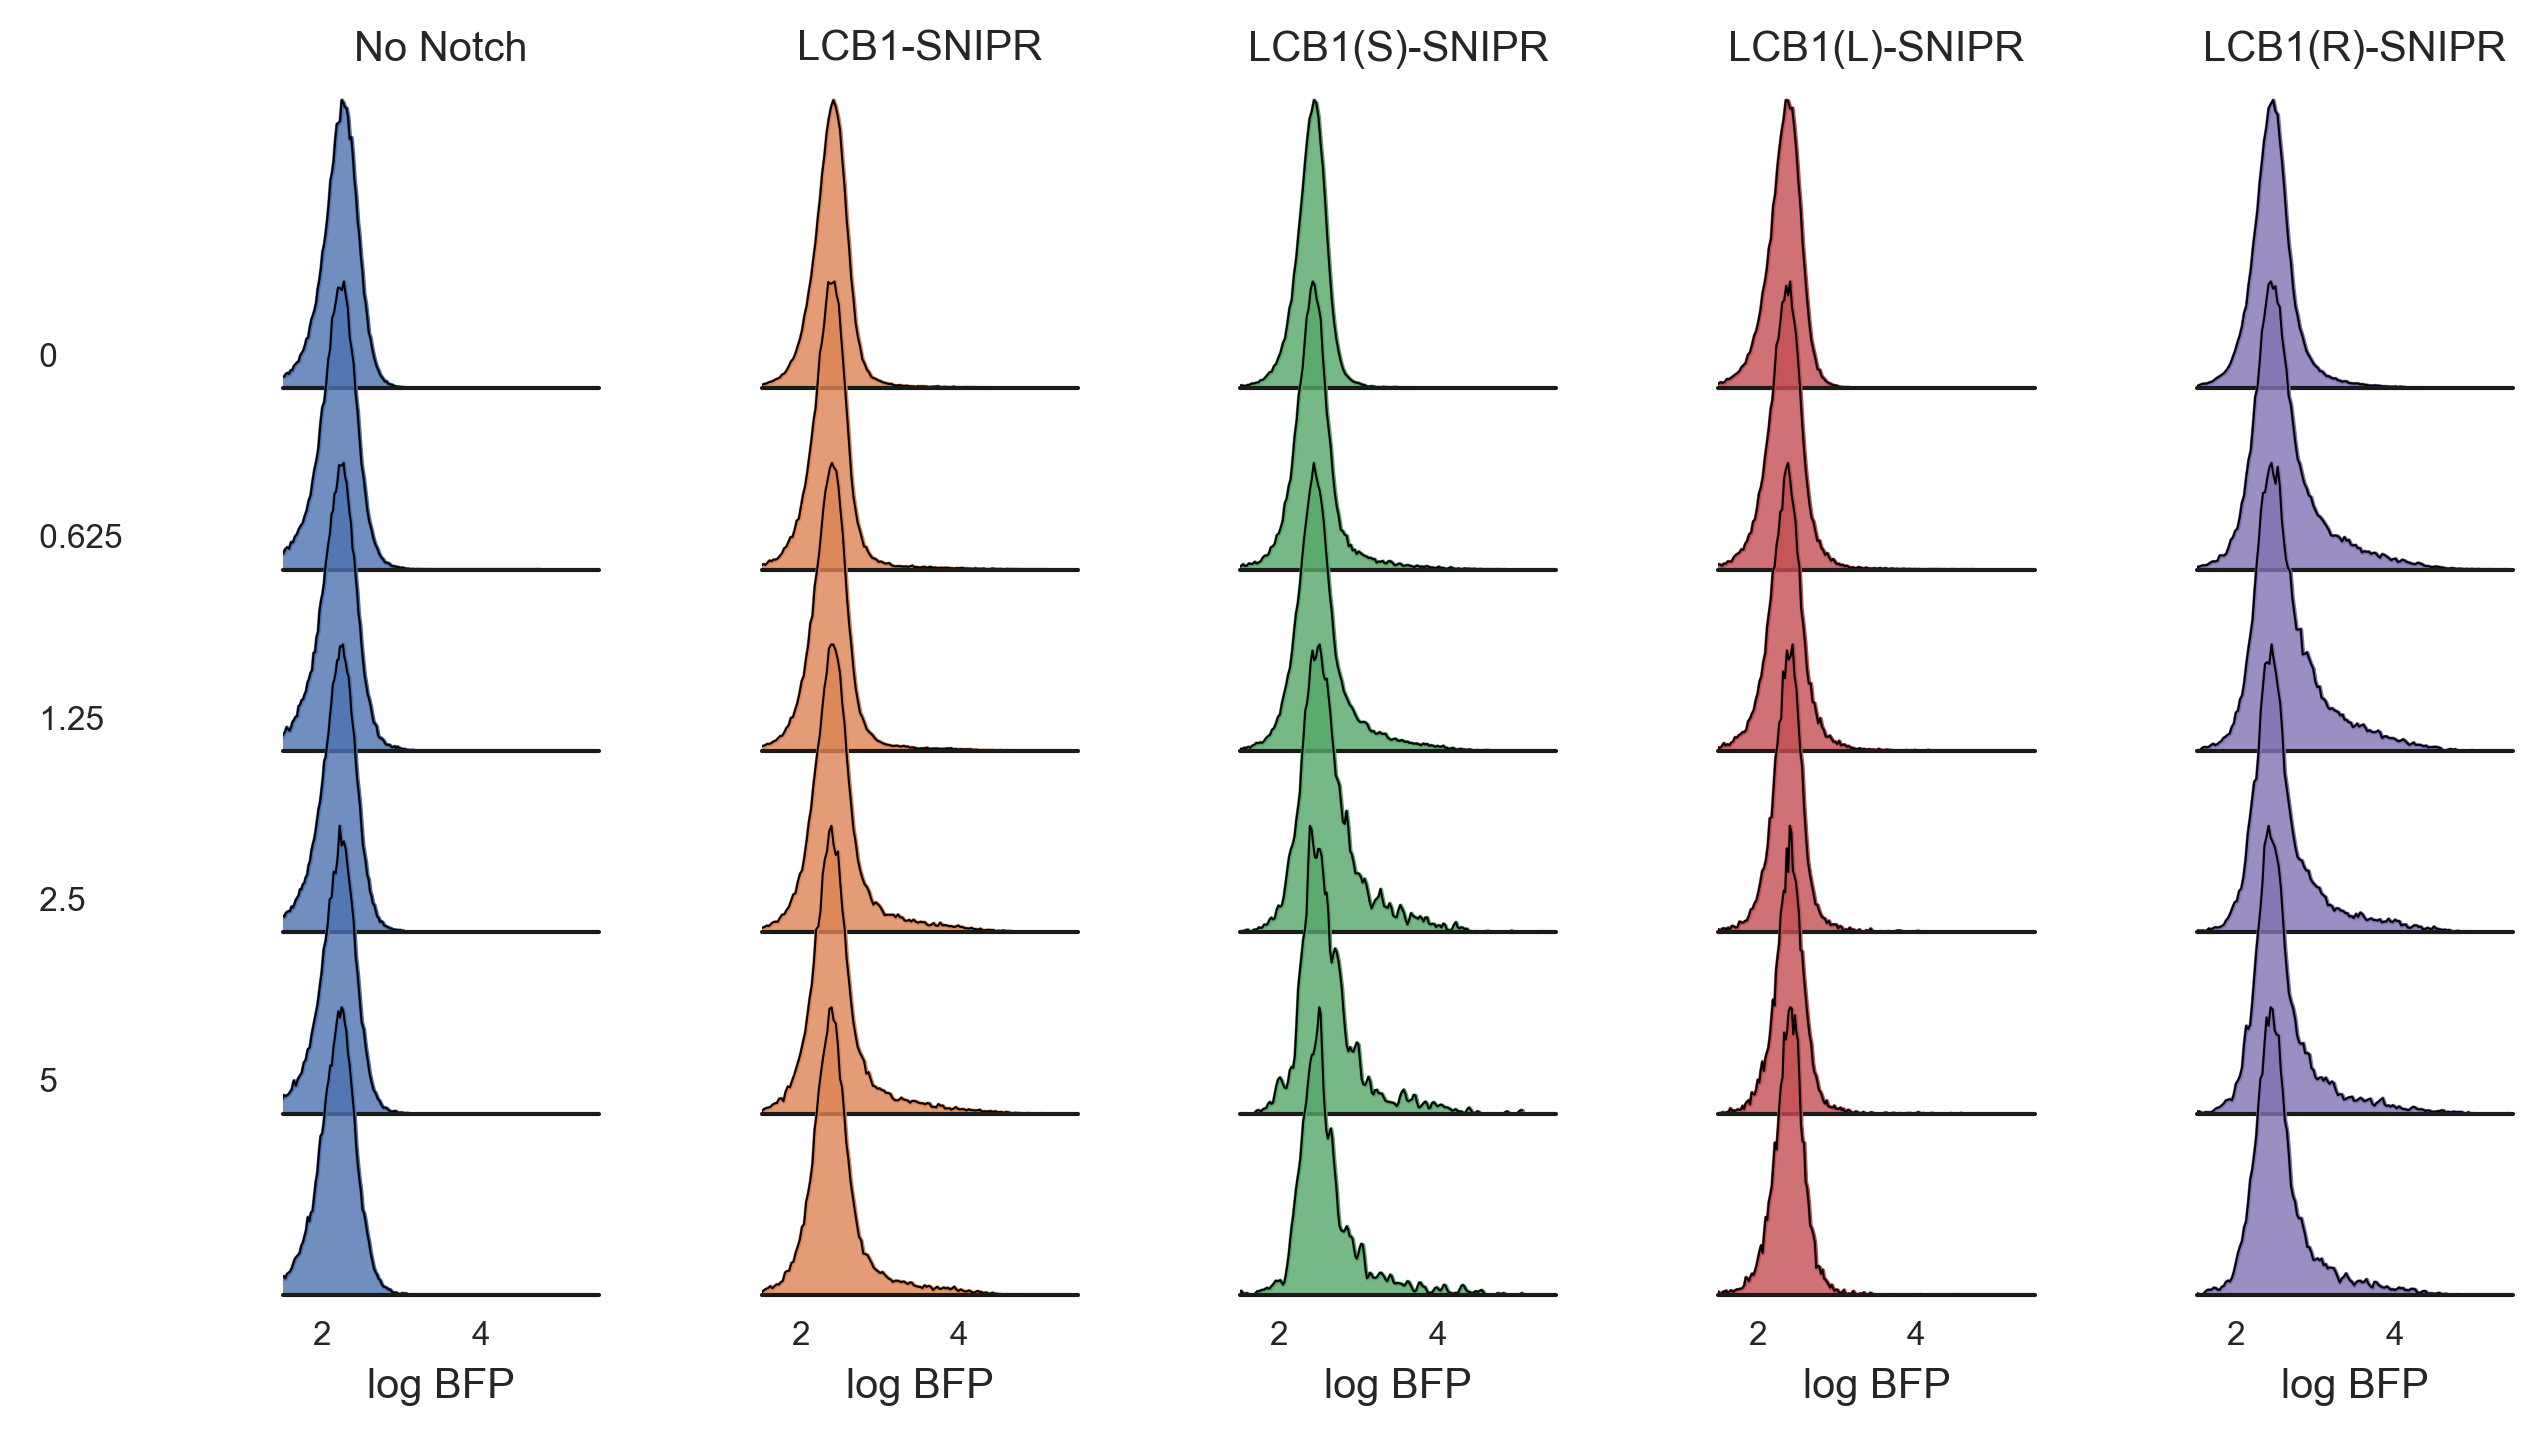

In [13]:
MOI = ['0', '0.625', '1.25', '2.5', '5', '10']
notches = ['No Notch','LCB1-SNIPR','LCB1(S)-SNIPR','LCB1(L)-SNIPR','LCB1(R)-SNIPR']
g = sns.FacetGrid(data=df2[(df2['Receiver'].isin(notches)) &
                           (df2['Strain'].isin(['None','WA1'])) &
                           (df2['logAPC-Cy7-A'] < 4) &
                           (df2['logFITC-A'] > 5)],
                  row='MOI', col='Receiver', sharey=False, aspect=2, height=0.8, 
                  hue='Receiver', row_order=MOI, col_order=notches, hue_order=notches, xlim=[1.5, 5.5])
g.map(sns.kdeplot, "logDAPI-A", shade=True, alpha=0.8, bw_adjust=0.2, cut=0)
g.map(sns.kdeplot, "logDAPI-A", color="black", lw=0.5, bw_adjust=.2, cut=0)
g.map(plt.axhline, y=0, lw=1, color='k', clip_on=False)

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.4)

left_axes = [g.facet_axis(r, 0) for r in range(len(notches))]
for ax in left_axes:
    dose = ax.get_title().split("=")[1].split('|')[0]
    ax.text(-0.8,0.1, "{}".format(dose), ha="left", va="center", 
            bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)

g.set_titles("")
top_axes = [g.facet_axis(0,c) for c in range(len(notches))]
for ax, notch in zip(top_axes, notches):
    ax.set_title(notch)
[ax.set(facecolor=(0, 0, 0, 0)) for ax in g.axes.flat]

# Remove axes details that don't play well with overlap
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set_xlabels("log BFP")
g.set_ylabels('')
g.fig.set_dpi(300)

In [8]:
activated = (df2
 .groupby(['Receiver','Strain','Replicate','MOI','Plate'])['DAPI-A']
 .median()
 .reset_index())

Text(0, 0.5, 'BFP MFI')

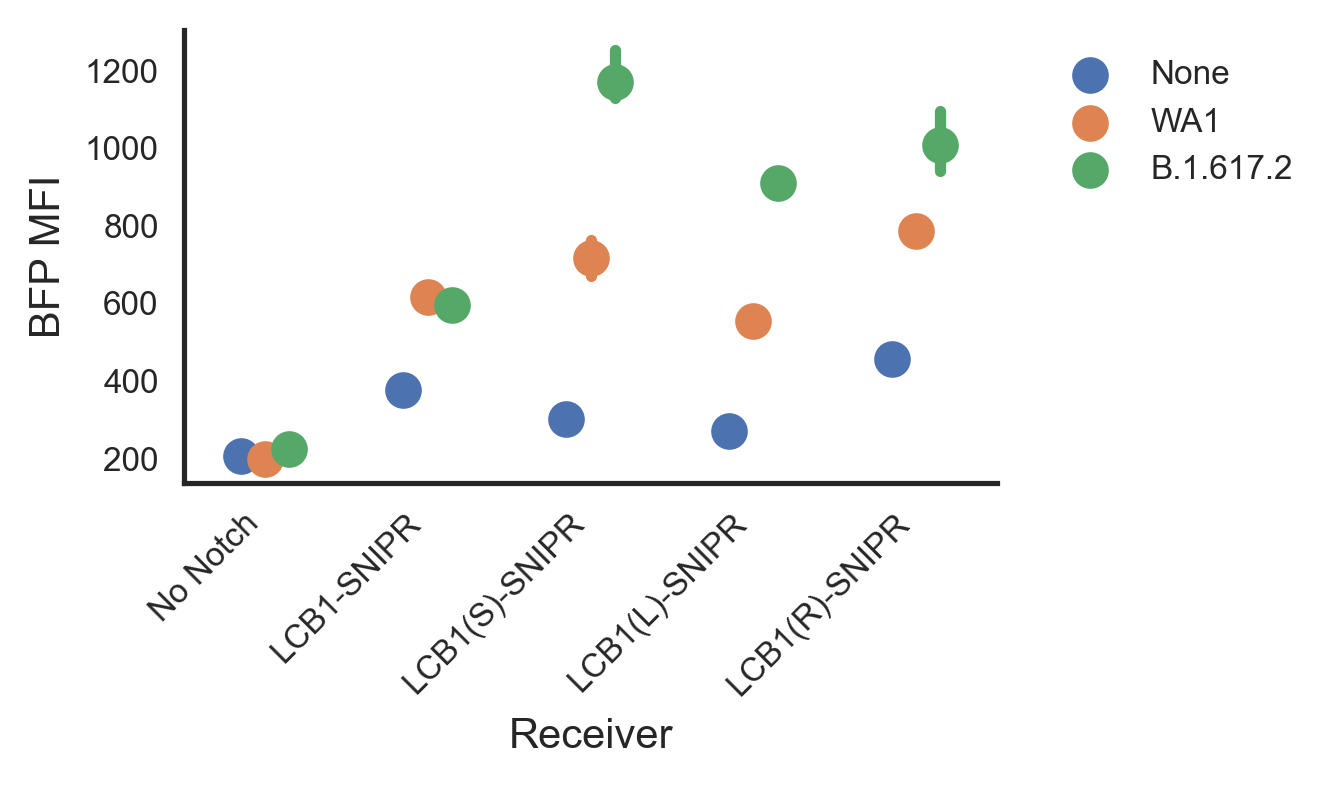

In [18]:
plt.figure(figsize=(3.5,2), dpi=300)
g = sns.pointplot(data=activated[activated['MOI'].isin(['0', '10'])], x='Receiver', y='DAPI-A', hue='Strain',
                  hue_order=['None','WA1','B.1.617.2'],
                  order=['No Notch','LCB1-SNIPR','LCB1(S)-SNIPR','LCB1(L)-SNIPR','LCB1(R)-SNIPR'],
                  join=False,
                  dodge=0.3)
plt.xticks(rotation=45, ha='right')
sns.despine()
g.legend().remove()
plt.legend(frameon=False, bbox_to_anchor=[1.4,1])
plt.ylabel('BFP MFI')

In [9]:
notches = ['No Notch','LCB1-SNIPR','LCB1(S)-SNIPR','LCB1(L)-SNIPR','LCB1(R)-SNIPR']
filters = ((df2['logFITC-A'] > 5) &
           (df2.Receiver.isin(notches)) &
           (df2['logAPC-Cy7-A'] < 4))
dist = df2[filters]['logDAPI-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
df_summary = (df2[filters]
              .groupby(['Receiver','Strain','MOI','Replicate','Plate'])['logDAPI-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

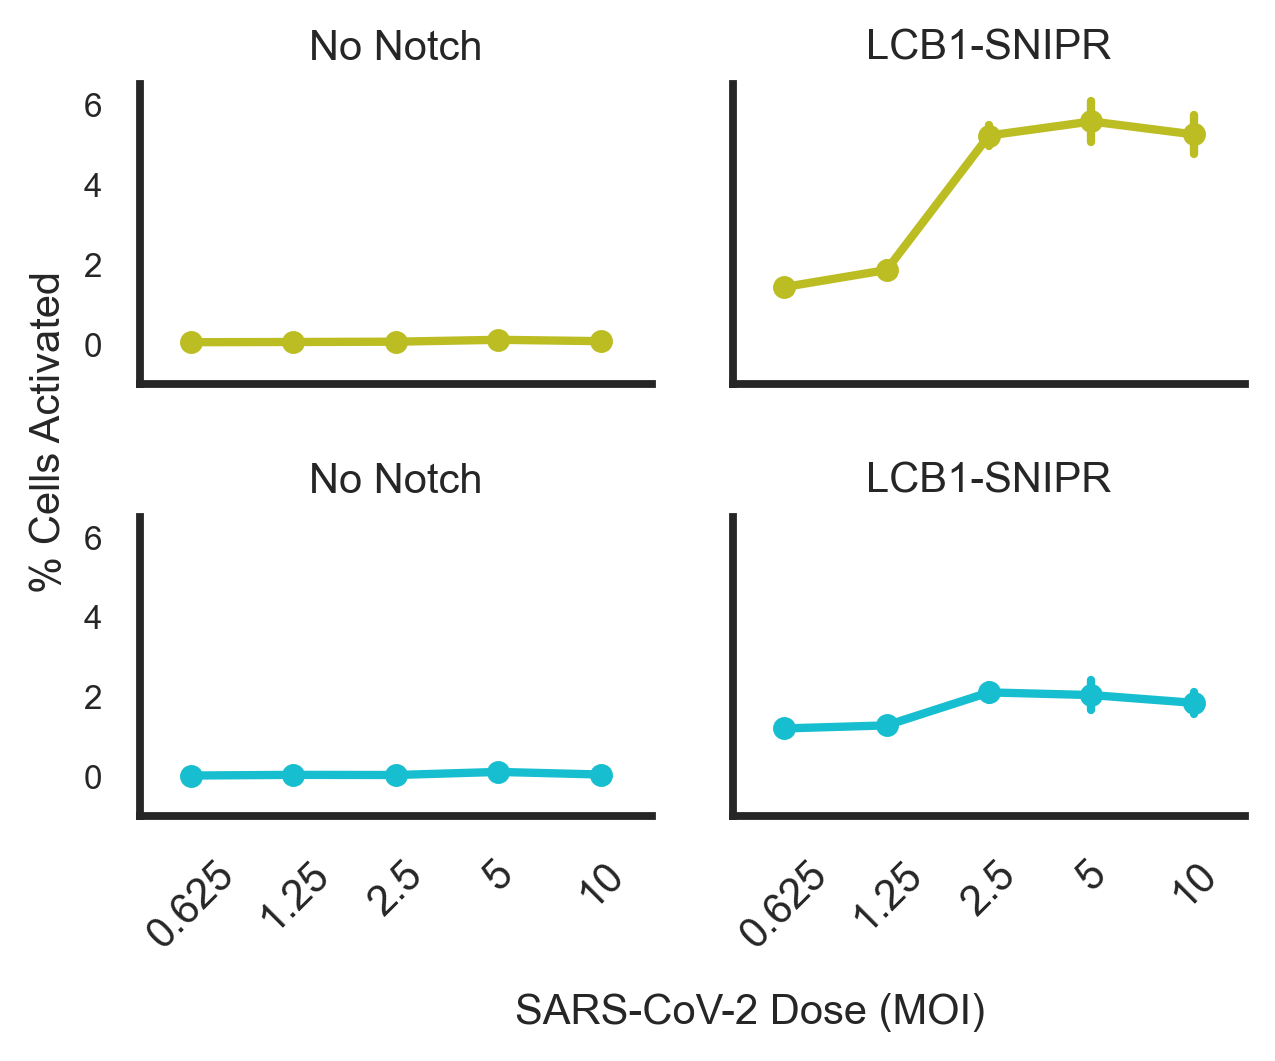

In [10]:
sns.set_context('talk')
notches = ['No Notch','LCB1-SNIPR']
with sns.color_palette(['tab:olive','tab:cyan']):
    g = sns.FacetGrid(data=df_summary[df_summary['Receiver'].isin(notches)], 
                      col='Receiver', row='Strain', hue='Strain', row_order=['WA1', 'B.1.617.2'], hue_order=['WA1', 'B.1.617.2'],
                      col_order=notches, height=2, aspect=1.2)
    g.map(sns.pointplot, 'MOI', 'logDAPI-A', order=['0.625', '1.25', '2.5', '5', '10'], errorbar='sd', markersize=4, linewidth=2, estimator='mean')
    g.set_ylabels('')
    g.set_xlabels('')
    g.fig.supylabel('% Cells Activated', fontsize=MEDIUM_SIZE, x=0.1, y=0.6)
    g.fig.supxlabel('SARS-CoV-2 Dose (MOI)', fontsize=MEDIUM_SIZE, y=0.1, x=0.6)
    g.set_titles('{col_name}', size=MEDIUM_SIZE)
    g.set_xticklabels(rotation=45, size=MEDIUM_SIZE)
    g.set(yticks=[0, 2, 4, 6], ylim=[-1,6.5])
    g.set_yticklabels(labels=[0,2,4,6], size=SMALL_SIZE)
    g.fig.tight_layout()
    g.figure.set_dpi(300)
    plt.savefig(outputdir+'sarscov2-activation.pdf',bbox_inches='tight')